# Importing Packages

In [1]:
# !pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime as dt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score,r2_score,mean_absolute_error,mean_squared_error,accuracy_score,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict
from sklearn import svm,metrics,tree,preprocessing,linear_model
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score,mean_squared_error,recall_score,confusion_matrix,f1_score,roc_curve, auc
from plotly.offline import iplot, init_notebook_mode
import pickle
import warnings
warnings.filterwarnings("ignore") 
import datetime as dt
from datetime import datetime
import plotly.express as px
import ortools.constraint_solver
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from scipy.optimize import linprog
from pylab import rcParams
import scipy
from scipy.stats.stats import pearsonr
import seaborn as sb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import utils
from sklearn.metrics import top_k_accuracy_score
from sklearn.metrics import classification_report

# Defining standard functions:

In [3]:
# Import the 'sub' function from the 're' module for regular expression substitution
from re import sub

# Define a function to convert a string to snake case
def snake_case(s):
    # Replace hyphens with spaces, then apply regular expression substitutions for title case conversion
    # and add an underscore between words, finally convert the result to lowercase
    return '_'.join(
        sub('([A-Z][a-z]+)', r' \1',
        sub('([A-Z]+)', r' \1',
        s.replace('-', ' '))).split()).lower()


# Importing datadests

In [4]:
import os
print([i for i in os.listdir('./')])

['EDA.ipynb', 'requirements.txt', 'README.md', '.gitignore', '.ipynb_checkpoints', 'Supply chain logisitcs problem.xlsx', '.git']


In [5]:
filename = 'Supply chain logisitcs problem.xlsx'
# import kagglehub
# # Download latest version
# path = kagglehub.dataset_download("harshsingh2209/supply-chain-analysis")
# MPSCData=pd.read_csv("/kaggle/input/supply-chain-analysis/supply_chain_data.csv")

In [6]:
import pandas as pd

sheet_names = pd.ExcelFile(filename).sheet_names
##['OrderList', 'FreightRates', 'WhCosts', 'WhCapacities', 'ProductsPerPlant', 'VmiCustomers', 'PlantPorts']
print(sheet_names)

['OrderList', 'FreightRates', 'WhCosts', 'WhCapacities', 'ProductsPerPlant', 'VmiCustomers', 'PlantPorts']


## Dataset is divided into 7 tables:

### OrderList
All orders that needs to be assigned a route 

### FreightRates  
Describes all available couriers, the weight gaps for each individual lane and rates associated.

### PlantPorts
Describes the allowed links between the warehouses and shipping ports in real world.

### ProductsPerPlant
Lists all supported warehouse-product combinations.

### WhCapacities
Lists warehouse capacities measured in number of orders per day.

### WhCosts
Specifies the cost associated in storing the products in given warehouse measured in dollars per unit.

### VmiCustomers
Lists all special cases, where warehouse is only allowed to support specific customer, while any other non-listed warehouse can supply any customer.

In [7]:
orders = pd.read_excel('Supply chain logisitcs problem.xlsx', sheet_name=sheet_names[0])
freight_rates = pd.read_excel('Supply chain logisitcs problem.xlsx', sheet_name=sheet_names[1])
plant_ports = pd.read_excel('Supply chain logisitcs problem.xlsx', sheet_name=sheet_names[6])
products_per_plant = pd.read_excel('Supply chain logisitcs problem.xlsx', sheet_name=sheet_names[4])
wh_capacities = pd.read_excel('Supply chain logisitcs problem.xlsx', sheet_name=sheet_names[3])
wh_costs = pd.read_excel('Supply chain logisitcs problem.xlsx', sheet_name=sheet_names[2])
vmi_customers = pd.read_excel('Supply chain logisitcs problem.xlsx', sheet_name=sheet_names[5])
vmi_customers['vmi_special'] = 1

### Joining all tables to get a primary table to use for subsequent EDA/ML

In [8]:
orders.columns = [snake_case(i) for i in orders.columns]
freight_rates.columns = [snake_case(i).replace('_cd', '') for i in freight_rates.columns]
plant_ports.columns = [snake_case(i) for i in plant_ports.columns]
products_per_plant.columns = [snake_case(i) for i in products_per_plant.columns]
wh_capacities.columns = [snake_case(i) for i in wh_capacities.columns]
wh_costs.columns = [snake_case(i) for i in wh_costs.columns]
vmi_customers.columns = [snake_case(i) for i in vmi_customers.columns]
vmi_customers.columns = [snake_case(i) for i in vmi_customers.columns]

In [9]:
freight_rates.rename(columns={'orig_port': 'origin', 'dest_port': 'destination', 'carrier': 'carrier'}, inplace=True)
orders.rename(columns={'orig_port': 'origin', 'dest_port': 'destination', 'carrier': 'carrier'}, inplace=True)

In [10]:
# orders.head(3)

## We will set aside freight_rates for now and use it for mapping downline
#### NOTE: freight rates maps carriers, ports, and destinations to rate by seeing if weight (from orders) falls into a range

In [11]:
freight_rates.head(3)

,carrier,origin,destination,minm_wgh_qty,max_wgh_qty,svc,minimum_cost,rate,mode_dsc,tpt_day_cnt,carrier_type
0,V444_6,PORT08,PORT09,250.0,499.99,DTD,43.2272,0.7132,AIR,2,V88888888_0
1,V444_6,PORT08,PORT09,65.0,69.99,DTD,43.2272,0.7512,AIR,2,V88888888_0
2,V444_6,PORT08,PORT09,60.0,64.99,DTD,43.2272,0.7892,AIR,2,V88888888_0


# plant_ports & products_per_place have a matching unique id 'plant_code'
## Joining both tables on 'plant_code' gives uus mapping from product -> warehouse -> port

In [12]:
plant_ports.head(3), plant_ports.shape, len(plant_ports.plant_code.unique())

(  plant_code    port
 0    PLANT01  PORT01
 1    PLANT01  PORT02
 2    PLANT02  PORT03,
 (22, 2),
 19)

In [13]:
products_per_plant.head(3), products_per_plant.shape, len(products_per_plant.plant_code.unique())

(  plant_code  product_id
 0    PLANT15     1698815
 1    PLANT17     1664419
 2    PLANT17     1664426,
 (2036, 2),
 19)

## Joining orders with products_per_plant & plant_ports gives us mapping from product -> warehouse -> port
#### Verified that port in plant_ports is the same as origin_port in orders
### Joining orders on plant_code, product_id, and origin_port gives us mapping from product -> warehouse -> port for a given order

In [ ]:
orders[orders.product_id == 1613321].head(3)

,order_id,order_date,origin_port,carrier,tpt,service_level,ship_ahead_day_count,ship_late_day_count,customer,product_id,plant_code,destination_port,unit_quantity,weight
4249,1.447391e+09,2013-05-26,PORT04,V444_0,2,DTP,0,0,V55555_26,1613321,PLANT03,PORT09,328,0.068124
4250,1.447389e+09,2013-05-26,PORT04,V444_0,2,DTP,0,0,V55555_26,1613321,PLANT03,PORT09,342,0.340621
5327,1.447391e+09,2013-05-26,PORT04,V444_0,2,DTP,0,0,V555555555_27,1613321,PLANT03,PORT09,749,2.833970


In [15]:
prouct_port_plant = products_per_plant.merge(plant_ports, on='plant_code', how='left').rename(columns={'port': 'origin_port'})
orders_port_plant = orders.merge(prouct_port_plant, on=['plant_code', 'product_id', 'origin_port'], how='left')
orders_port_plant.head(3)
## Now we have a mapping from product -> warehouse -> port for a given order

,order_id,order_date,origin_port,carrier,tpt,service_level,ship_ahead_day_count,ship_late_day_count,customer,product_id,plant_code,destination_port,unit_quantity,weight
0,1.447296e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,808,14.30
1,1.447158e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,3188,87.94
2,1.447139e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,2331,61.20


In [16]:
orders_port_plant.shape, orders.shape

((9215, 14), (9215, 14))

In [17]:
### Converting order_id to string
orders_port_plant['order_id'] = orders_port_plant['order_id'].astype(str)
orders_port_plant.head(10)


,order_id,order_date,origin_port,carrier,tpt,service_level,ship_ahead_day_count,ship_late_day_count,customer,product_id,plant_code,destination_port,unit_quantity,weight
0,1447296446.7,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,808,14.30
1,1447158014.7,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,3188,87.94
2,1447138898.7,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,2331,61.20
3,1447363527.7,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,847,16.16
4,1447363980.7,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,2163,52.34
5,1447351440.7,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,3332,92.80
6,1447320235.7,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,1782,46.90
7,1447158018.7,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,427,2.86
8,1447219340.7,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,1291,26.60
9,1447398415.7,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,2294,62.20


In [18]:
wh_capacities.head(3), ' ', wh_costs.head(3),  wh_capacities.shape, wh_costs.shape

(  plant_id  daily_capacity
 0  PLANT15              11
 1  PLANT17               8
 2  PLANT18             111,
 ' ',
         wh  cost/unit
 0  PLANT15   1.415063
 1  PLANT17   0.428947
 2  PLANT18   2.036254,
 (19, 2),
 (19, 2))

In [19]:
wh_costs.rename(columns={'wh': 'plant_code'}, inplace=True)
wh_capacities.rename(columns={'plant_id': 'plant_code'}, inplace=True)

In [20]:
wh_capacities.head(3), wh_costs.head(3), wh_capacities.shape, wh_costs.shape

(  plant_code  daily_capacity
 0    PLANT15              11
 1    PLANT17               8
 2    PLANT18             111,
   plant_code  cost/unit
 0    PLANT15   1.415063
 1    PLANT17   0.428947
 2    PLANT18   2.036254,
 (19, 2),
 (19, 2))

In [21]:
wh_data = wh_capacities.merge(wh_costs, on='plant_code', how='left')
wh_data.shape,

((19, 3),)

### Merge wh_data with orders_port_plant on plant_code to get all but two tables in one table


In [22]:
order_master = orders_port_plant.merge(wh_data, on='plant_code', how='left')

## EDA On Order Master
#### For the sake of simplicity, we are not going to use the vmi_customers table or the freight_rates table

In [23]:
order_master.head(3)

,order_id,order_date,origin_port,carrier,tpt,service_level,ship_ahead_day_count,ship_late_day_count,customer,product_id,plant_code,destination_port,unit_quantity,weight,daily_capacity,cost/unit
0,1447296446.7,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,808,14.30,457,1.919808
1,1447158014.7,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,3188,87.94,457,1.919808
2,1447138898.7,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,2331,61.20,457,1.919808


### Looking at order quantity, number of orders, average capacity and cost/unit

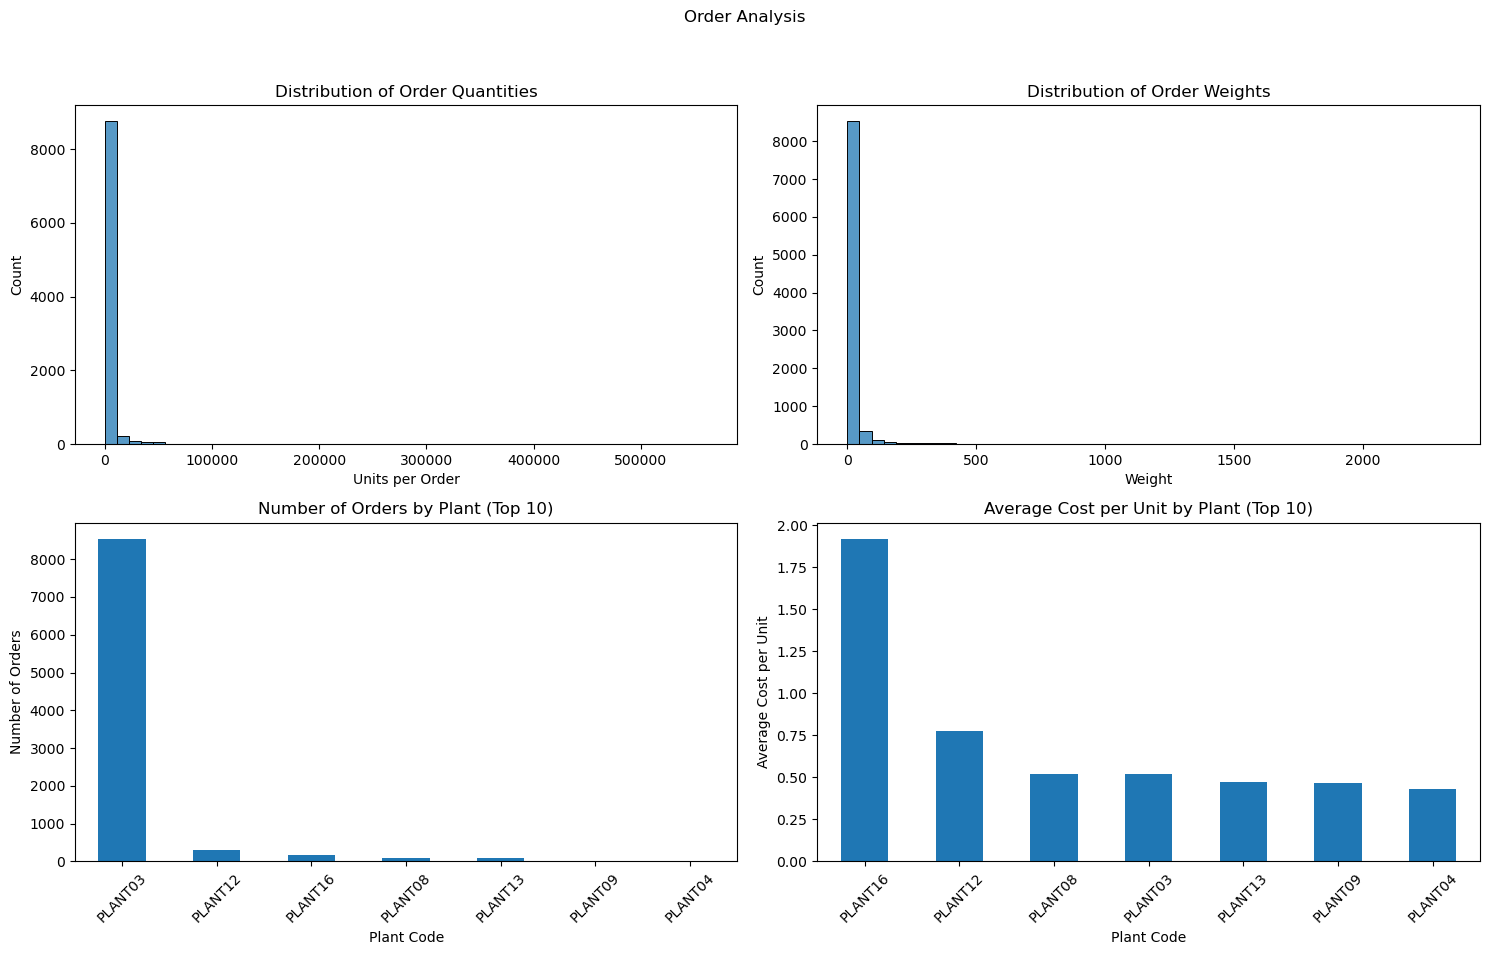

In [24]:
# Create subplots for different analyses
# plt.style.use('seaborn')
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Order Analysis')

# 1. Distribution of unit quantities per order
sns.histplot(data=order_master, x='unit_quantity', bins=50, ax=axes[0,0])
axes[0,0].set_title('Distribution of Order Quantities')
axes[0,0].set_xlabel('Units per Order')
axes[0,0].set_ylabel('Count')

# 2. Distribution of order weights
sns.histplot(data=order_master, x='weight', bins=50, ax=axes[0,1])
axes[0,1].set_title('Distribution of Order Weights')
axes[0,1].set_xlabel('Weight')
axes[0,1].set_ylabel('Count')

# 3. Orders by plant code
order_counts = order_master['plant_code'].value_counts().head(10)
order_counts.plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Number of Orders by Plant (Top 10)')
axes[1,0].set_xlabel('Plant Code')
axes[1,0].set_ylabel('Number of Orders')
axes[1,0].tick_params(axis='x', rotation=45)

# 4. Average cost/unit by plant
avg_cost = order_master.groupby('plant_code')['cost/unit'].mean().sort_values(ascending=False).head(10)
avg_cost.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Average Cost per Unit by Plant (Top 10)')
axes[1,1].set_xlabel('Plant Code')
axes[1,1].set_ylabel('Average Cost per Unit')
axes[1,1].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()

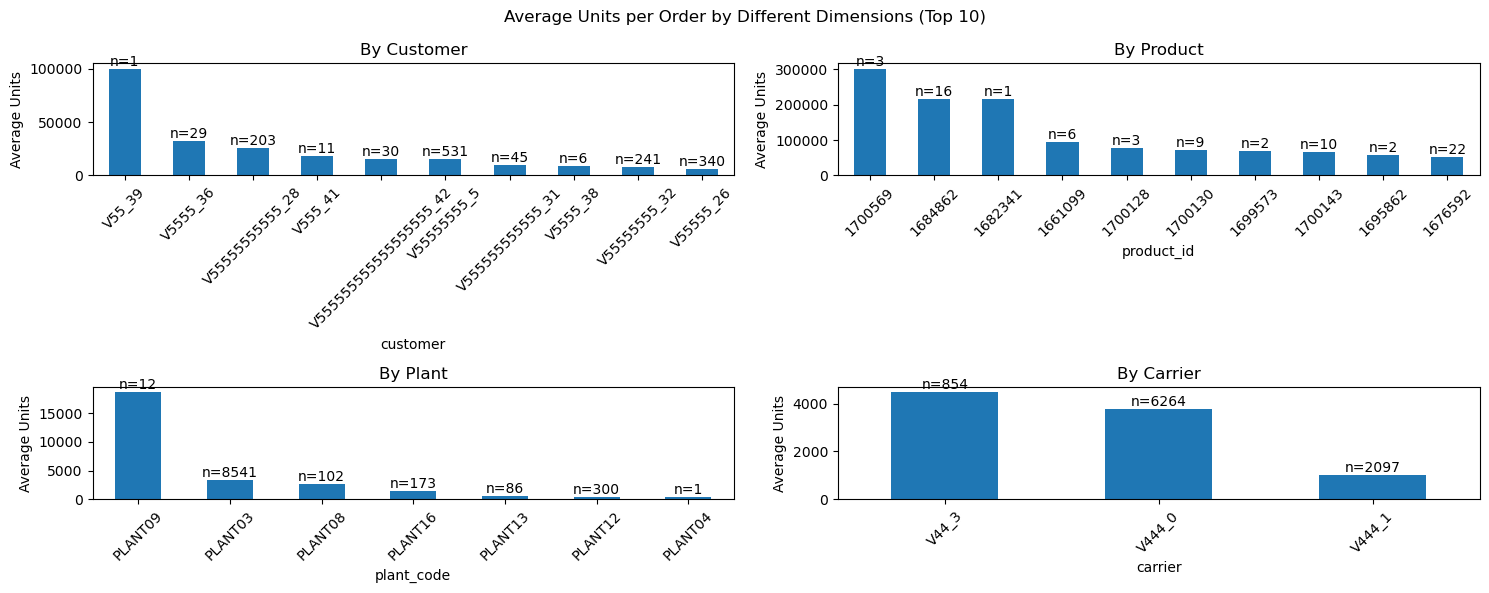

In [32]:
# Group by different dimensions and calculate mean unit quantity
unit_breakdowns = {
    'By Customer': order_master.groupby('customer')['unit_quantity'].agg(['mean', 'count']).nlargest(10, 'mean'),
    'By Product': order_master.groupby('product_id')['unit_quantity'].agg(['mean', 'count']).nlargest(10, 'mean'),
    'By Plant': order_master.groupby('plant_code')['unit_quantity'].agg(['mean', 'count']).nlargest(10, 'mean'),
    'By Carrier': order_master.groupby('carrier')['unit_quantity'].agg(['mean', 'count']).nlargest(10, 'mean')
}

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 6))
fig.suptitle('Average Units per Order by Different Dimensions (Top 10)')

# Plot each breakdown
for (title, data), ax in zip(unit_breakdowns.items(), axes.ravel()):
    data['mean'].plot(kind='bar', ax=ax)
    ax.set_title(title)
    ax.set_ylabel('Average Units')
    ax.tick_params(axis='x', rotation=45)
    
    # Add count as text on top of bars
    for i, (mean, count) in enumerate(zip(data['mean'], data['count'])):
        ax.text(i, mean, f'n={count}', ha='center', va='bottom')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Which Origin -> Destination combinations have the most orders?

In [31]:
order_master[['origin_port', 'destination_port']].groupby(['origin_port', 'destination_port']).size().reset_index(name='order_count')

,origin_port,destination_port,order_count
0,PORT04,PORT09,9041
1,PORT05,PORT09,1
2,PORT09,PORT09,173


In [45]:
order_master.head()

,order_id,order_date,origin_port,carrier,tpt,service_level,ship_ahead_day_count,ship_late_day_count,customer,product_id,plant_code,destination_port,unit_quantity,weight,daily_capacity,cost/unit
0,1447296446.7,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,808,14.30,457,1.919808
1,1447158014.7,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,3188,87.94,457,1.919808
2,1447138898.7,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,2331,61.20,457,1.919808
3,1447363527.7,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,847,16.16,457,1.919808
4,1447363980.7,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,2163,52.34,457,1.919808


# Findings:
#### Columns we will filter 
1. Dataset only contains orders for 1 date
2. 9041/9215 observations are port 4 -> port 9, otherwise port9 -> port9
#### Columns that are more useful:
1. plant_code, carrier, customer

In [18]:
import networkx as nx
G=nx.from_pandas_edgelist(freight_rates[["orig_port", "dest_port", 'rate']].groupby(['orig_port', 'dest_port']).mean().reset_index(), "orig_port", "dest_port", edge_attr = 'rate',create_using=nx.MultiGraph())
# Set the figure size
plt.figure(figsize=(20, 12))

# If G is a multigraph, create a simple graph version
G_simple = nx.Graph(G)  # This will keep only one edge between each pair of nodes

# Get the layout for the simple graph
pos = nx.spring_layout(G_simple, k=1.5)

# Get edge labels (make sure to use the simple graph)
edge_labels = nx.get_edge_attributes(G_simple, 'rate')  # or whatever attribute you're using for labels

# Draw the graph
nx.draw_networkx_nodes(G_simple, pos)
nx.draw_networkx_edges(G_simple, pos)
nx.draw_networkx_edge_labels(G_simple, pos, edge_labels=edge_labels, font_size=15)
nx.draw_networkx_labels(G_simple, pos, font_size=10)

# Add padding around the graph
plt.margins(0.2)

# Ensure the layout fills the figure
plt.tight_layout()

# Show the plot
plt.show()

KeyError: "['orig_port', 'dest_port'] not in index"

In [13]:
freight_rates.shape, orders.shape, plant_ports.shape, products_per_plant.shape, wh_capacities.shape, wh_costs.shape, vmi_customers.shape


((1540, 11), (9215, 14), (22, 2), (2036, 2), (19, 2), (19, 2), (14, 3))

In [14]:
[i for i in freight_rates.columns if i in orders.columns], [i for i in plant_ports.columns if i in orders.columns] \
    , [i for i in products_per_plant.columns if i in orders.columns]\
        , [i for i in wh_capacities.columns if i in orders.columns]\
            , [i for i in wh_costs.columns if i in orders.columns]\
                , [i for i in vmi_customers.columns if i in orders.columns]

(['carrier'],
 ['plant_code'],
 ['plant_code', 'product_id'],
 [],
 [],
 ['plant_code'])

In [15]:

wh_capacities.head(3)

,plant_id,daily_capacity
0,PLANT15,11
1,PLANT17,8
2,PLANT18,111




Order ID is ID of the order made by the customer, product ID is the specific product ID customer ordered.



"tpt_day_cnt" in the FrieghtRates table means transportation day count, i.e. estimated shipping time.



WhCapacities correspond to the number of orders. For example, let's say Customer 1 requests 10 units of X, Customer 2 requests 20 units of Y. The total number of orders is 2, thus total capacity in "whCapacity" is 2.



WhCapacities table is the maximum number of orders that can be processed per each plant, it is not dependant on specific products.



The OrderList contains historical records of how the orders were routed and demand satisfied. The whCapacities and rest of the tables are the current state constraints of the network. Thus, we can calculate the costs of historical network and also optimize for the new constraints.



In order to build Linear Programming (LP) model, you would take the following from the OrderList: the product ID that needs to be shipped, the destination port, unit quantity (for cost) and unit weight (for weight constraints). And then use the limits of those constraints from other tables.



Questions: There is a Carrier V44_3 in OrderList table, but it is missing in the FreightRates table? V44_3 is a carrier that was historically used for supplying given demand, but since it has been discontinued and therefore do not appear in the Freight Rates List. Also, all of the V44_3 instances are CRF - i.e. customer arranges their own shipping and hence cost is not calculated either way.



# Date Range of Dataset:
##### Split from __ to __ to get a 80/20 split for test and training sets
## Questions (EDA):

## Questions (ML):
* How much growth by region(?) will we see by __